## Load data & set configuration

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy
from tqdm import tqdm
from torchsummary import summary

def fix_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    numpy.random.seed(seed)

fix_seed(2021)

config = {
    "batch_size": 100,
    "learning_rate": 0.008,
    "epochs": 100,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root='./cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=config['batch_size'], shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=config['batch_size'], shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Preveiw photos

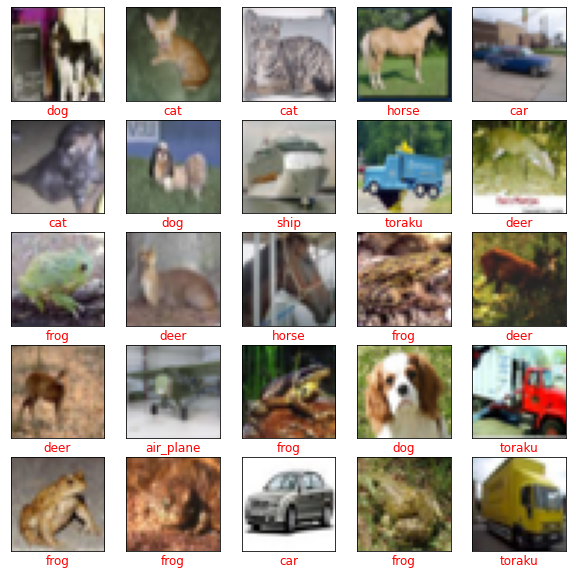

In [2]:
class_names = ['air_plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'toraku']

# get some random training images

plt.figure(figsize=(10, 10))
counter = 0
for images, labels in trainloader:
    for i, img in enumerate(images):
        plt.subplot(5, 5, counter+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = img/2 + 0.5   # unmornalize
        # convert (C,H,W) to (H,W,C)
        img_show = numpy.transpose(img, (1, 2, 0))
        plt.imshow(img_show, cmap=plt.cm.binary)
        plt.xlabel(class_names[int(labels[i])], color='red', fontsize='large')
        counter += 1
        if counter == 25:
            break
    if counter == 25:
        break

plt.show()


## Build Model

In [3]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3)
        self.batch1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.batch2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 128, 2)
        self.batch3 = torch.nn.BatchNorm2d(128)
        self.conv4 = torch.nn.Conv2d(128, 256, 2)
        self.batch4 = torch.nn.BatchNorm2d(256)
        self.conv5 = torch.nn.Conv2d(256, 512, 2)
        self.batch5 = torch.nn.BatchNorm2d(512)
        self.maxpooling = torch.nn.MaxPool2d(2)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(12800, 1024)
        self.linear2 = torch.nn.Linear(1024, 10)
        self.dropout = torch.nn.Dropout(.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpooling(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = self.maxpooling(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


In [4]:
def compile(model, train_loader, test_loader, input_shape, epochs, optimizer, loss):
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    for epoch in range(epochs):
        #---------------------------- Train ----------------------------
        num_train = 0
        num_correct_train = 0
        print("Epoch %d/%d" % (epoch+1, epochs))
        for (xList, yList) in tqdm(train_loader):
            xList, yList = torch.autograd.Variable(
                xList), torch.autograd.Variable(yList)
            optimizer.zero_grad()

            if torch.cuda.is_available():
                xList = xList.type(torch.cuda.FloatTensor)
                yList = yList.type(torch.cuda.LongTensor)

            outputs = model(xList)
            train_loss_func = loss(outputs, yList)
            train_loss_func.backward()
            optimizer.step()

            num_train += len(yList)  # i.e., add bath size

            # torch.max() return a list where list[0]: val list[1]: index
            predicts = torch.max(outputs.data, 1)[1]
            num_correct_train += (predicts == yList).float().sum()
        
        train_acc.append(num_correct_train / num_train)
        train_loss.append(train_loss_func.data)

        #---------------------------- Test ----------------------------
        num_test = 0
        num_correct_test = 0
        for (xList, yList) in test_loader:
            if torch.cuda.is_available():
                xList = xList.type(torch.cuda.FloatTensor)
                yList = yList.type(torch.cuda.LongTensor)
            
            outputs = model(xList)
            test_loss_func = loss(outputs, yList)

            num_test += len(yList)
            predicts = torch.max(outputs.data, 1)[1]
            num_correct_test += (predicts == yList).float().sum()

        test_acc.append(num_correct_test / num_test)
        test_loss.append(test_loss_func.data)
        print('- loss: %.4f - accuracy: %.4f - test_loss %.4f - test_acc %.4f' % 
              (train_loss[epoch].item(), train_acc[epoch].item(), 
               test_loss[epoch].item(), test_acc[epoch].item()))
    return train_loss, train_acc, test_loss, test_acc


## Training

In [5]:
model = MyModel()
model.to(config['device'])
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
         MaxPool2d-6           [-1, 64, 14, 14]               0
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 13, 13]          32,896
       BatchNorm2d-9          [-1, 128, 13, 13]             256
             ReLU-10          [-1, 128, 13, 13]               0
           Conv2d-11          [-1, 256, 12, 12]         131,328
      BatchNorm2d-12          [-1, 256, 12, 12]             512
             ReLU-13          [-1, 256, 12, 12]               0
           Conv2d-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
result = compile(model, trainloader, testloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
    model.parameters(), lr=config["learning_rate"]), loss=torch.nn.CrossEntropyLoss())

Epoch 1/100


100%|██████████| 500/500 [00:11<00:00, 43.48it/s]


- loss: 1.7665 - accuracy: 0.2487 - test_loss 1.6811 - test_acc 0.3600
Epoch 2/100


100%|██████████| 500/500 [00:11<00:00, 44.49it/s]


- loss: 1.6069 - accuracy: 0.4079 - test_loss 1.4655 - test_acc 0.4609
Epoch 3/100


100%|██████████| 500/500 [00:11<00:00, 44.53it/s]


- loss: 1.3128 - accuracy: 0.4826 - test_loss 1.3185 - test_acc 0.5176
Epoch 4/100


100%|██████████| 500/500 [00:11<00:00, 44.86it/s]


- loss: 1.2952 - accuracy: 0.5264 - test_loss 1.3607 - test_acc 0.5447
Epoch 5/100


100%|██████████| 500/500 [00:11<00:00, 44.93it/s]


- loss: 1.4734 - accuracy: 0.5715 - test_loss 1.1261 - test_acc 0.5923
Epoch 6/100


100%|██████████| 500/500 [00:11<00:00, 44.64it/s]


- loss: 1.0979 - accuracy: 0.6107 - test_loss 1.1074 - test_acc 0.6253
Epoch 7/100


100%|██████████| 500/500 [00:11<00:00, 44.27it/s]


- loss: 0.9051 - accuracy: 0.6385 - test_loss 0.9017 - test_acc 0.6608
Epoch 8/100


100%|██████████| 500/500 [00:11<00:00, 45.32it/s]


- loss: 0.8556 - accuracy: 0.6668 - test_loss 1.1049 - test_acc 0.6516
Epoch 9/100


100%|██████████| 500/500 [00:11<00:00, 44.54it/s]


- loss: 0.7575 - accuracy: 0.6912 - test_loss 0.9432 - test_acc 0.6903
Epoch 10/100


100%|██████████| 500/500 [00:11<00:00, 45.13it/s]


- loss: 0.8802 - accuracy: 0.7084 - test_loss 0.8414 - test_acc 0.6832
Epoch 11/100


100%|██████████| 500/500 [00:11<00:00, 45.26it/s]


- loss: 0.6186 - accuracy: 0.7182 - test_loss 0.8321 - test_acc 0.6989
Epoch 12/100


100%|██████████| 500/500 [00:11<00:00, 44.81it/s]


- loss: 0.9634 - accuracy: 0.7252 - test_loss 0.8664 - test_acc 0.7022
Epoch 13/100


100%|██████████| 500/500 [00:11<00:00, 45.41it/s]


- loss: 0.7317 - accuracy: 0.7384 - test_loss 0.8588 - test_acc 0.7116
Epoch 14/100


100%|██████████| 500/500 [00:11<00:00, 44.97it/s]


- loss: 0.7625 - accuracy: 0.7494 - test_loss 0.8286 - test_acc 0.7266
Epoch 15/100


100%|██████████| 500/500 [00:11<00:00, 45.21it/s]


- loss: 0.6826 - accuracy: 0.7549 - test_loss 0.8516 - test_acc 0.7083
Epoch 16/100


100%|██████████| 500/500 [00:11<00:00, 45.37it/s]


- loss: 0.7027 - accuracy: 0.7572 - test_loss 0.8531 - test_acc 0.7195
Epoch 17/100


100%|██████████| 500/500 [00:11<00:00, 45.27it/s]


- loss: 0.9413 - accuracy: 0.7695 - test_loss 0.7653 - test_acc 0.7209
Epoch 18/100


100%|██████████| 500/500 [00:10<00:00, 45.52it/s]


- loss: 0.6016 - accuracy: 0.7717 - test_loss 0.8524 - test_acc 0.7278
Epoch 19/100


100%|██████████| 500/500 [00:11<00:00, 45.28it/s]


- loss: 0.7575 - accuracy: 0.7811 - test_loss 0.8261 - test_acc 0.7278
Epoch 20/100


100%|██████████| 500/500 [00:10<00:00, 45.50it/s]


- loss: 0.5438 - accuracy: 0.7819 - test_loss 0.9113 - test_acc 0.7249
Epoch 21/100


100%|██████████| 500/500 [00:11<00:00, 45.45it/s]


- loss: 0.6176 - accuracy: 0.7926 - test_loss 0.7560 - test_acc 0.7299
Epoch 22/100


100%|██████████| 500/500 [00:11<00:00, 45.38it/s]


- loss: 0.5527 - accuracy: 0.7961 - test_loss 1.0111 - test_acc 0.7104
Epoch 23/100


100%|██████████| 500/500 [00:10<00:00, 45.76it/s]


- loss: 0.6447 - accuracy: 0.8035 - test_loss 0.8984 - test_acc 0.7163
Epoch 24/100


100%|██████████| 500/500 [00:11<00:00, 44.81it/s]


- loss: 0.5891 - accuracy: 0.8053 - test_loss 0.8235 - test_acc 0.7453
Epoch 25/100


100%|██████████| 500/500 [00:10<00:00, 45.47it/s]


- loss: 0.6311 - accuracy: 0.8141 - test_loss 1.1266 - test_acc 0.7151
Epoch 26/100


100%|██████████| 500/500 [00:11<00:00, 45.45it/s]


- loss: 0.5248 - accuracy: 0.8224 - test_loss 1.1161 - test_acc 0.7261
Epoch 27/100


100%|██████████| 500/500 [00:11<00:00, 45.34it/s]


- loss: 0.6133 - accuracy: 0.8184 - test_loss 0.9755 - test_acc 0.7141
Epoch 28/100


100%|██████████| 500/500 [00:10<00:00, 45.61it/s]


- loss: 0.5431 - accuracy: 0.8272 - test_loss 1.0801 - test_acc 0.7368
Epoch 29/100


100%|██████████| 500/500 [00:11<00:00, 45.42it/s]


- loss: 0.3906 - accuracy: 0.8407 - test_loss 1.3999 - test_acc 0.6758
Epoch 30/100


100%|██████████| 500/500 [00:11<00:00, 44.77it/s]


- loss: 0.7730 - accuracy: 0.8004 - test_loss 0.9925 - test_acc 0.7323
Epoch 31/100


100%|██████████| 500/500 [00:11<00:00, 45.29it/s]


- loss: 0.4820 - accuracy: 0.8520 - test_loss 0.9613 - test_acc 0.7276
Epoch 32/100


100%|██████████| 500/500 [00:10<00:00, 45.62it/s]


- loss: 0.2987 - accuracy: 0.8551 - test_loss 1.0309 - test_acc 0.7475
Epoch 33/100


100%|██████████| 500/500 [00:11<00:00, 45.14it/s]


- loss: 0.5071 - accuracy: 0.8603 - test_loss 0.9198 - test_acc 0.7462
Epoch 34/100


100%|██████████| 500/500 [00:10<00:00, 45.72it/s]


- loss: 0.3747 - accuracy: 0.8654 - test_loss 1.0922 - test_acc 0.7447
Epoch 35/100


100%|██████████| 500/500 [00:11<00:00, 45.10it/s]


- loss: 0.5220 - accuracy: 0.8653 - test_loss 1.2718 - test_acc 0.7157
Epoch 36/100


100%|██████████| 500/500 [00:11<00:00, 45.40it/s]


- loss: 0.3410 - accuracy: 0.8691 - test_loss 1.3678 - test_acc 0.7090
Epoch 37/100


100%|██████████| 500/500 [00:10<00:00, 45.50it/s]


- loss: 0.3163 - accuracy: 0.8733 - test_loss 1.0062 - test_acc 0.7381
Epoch 38/100


100%|██████████| 500/500 [00:11<00:00, 45.38it/s]


- loss: 0.3472 - accuracy: 0.8752 - test_loss 1.3670 - test_acc 0.7271
Epoch 39/100


100%|██████████| 500/500 [00:10<00:00, 45.84it/s]


- loss: 0.3351 - accuracy: 0.8817 - test_loss 1.4267 - test_acc 0.7363
Epoch 40/100


100%|██████████| 500/500 [00:10<00:00, 45.82it/s]


- loss: 0.4493 - accuracy: 0.8842 - test_loss 1.4403 - test_acc 0.7253
Epoch 41/100


100%|██████████| 500/500 [00:10<00:00, 45.75it/s]


- loss: 0.5094 - accuracy: 0.8879 - test_loss 1.1486 - test_acc 0.7184
Epoch 42/100


100%|██████████| 500/500 [00:10<00:00, 46.02it/s]


- loss: 0.3060 - accuracy: 0.8873 - test_loss 0.9115 - test_acc 0.7401
Epoch 43/100


100%|██████████| 500/500 [00:10<00:00, 45.79it/s]


- loss: 0.3402 - accuracy: 0.8922 - test_loss 1.3842 - test_acc 0.7363
Epoch 44/100


100%|██████████| 500/500 [00:10<00:00, 45.65it/s]


- loss: 0.5301 - accuracy: 0.8927 - test_loss 1.2364 - test_acc 0.7372
Epoch 45/100


100%|██████████| 500/500 [00:11<00:00, 45.33it/s]


- loss: 0.3858 - accuracy: 0.9003 - test_loss 1.4756 - test_acc 0.7281
Epoch 46/100


100%|██████████| 500/500 [00:10<00:00, 45.85it/s]


- loss: 0.2863 - accuracy: 0.9033 - test_loss 1.3209 - test_acc 0.7448
Epoch 47/100


100%|██████████| 500/500 [00:10<00:00, 45.91it/s]


- loss: 0.4092 - accuracy: 0.9008 - test_loss 1.3270 - test_acc 0.7337
Epoch 48/100


100%|██████████| 500/500 [00:10<00:00, 45.54it/s]


- loss: 0.1757 - accuracy: 0.9005 - test_loss 1.4005 - test_acc 0.7136
Epoch 49/100


100%|██████████| 500/500 [00:10<00:00, 46.32it/s]


- loss: 0.4488 - accuracy: 0.9056 - test_loss 1.4785 - test_acc 0.7127
Epoch 50/100


100%|██████████| 500/500 [00:10<00:00, 46.22it/s]


- loss: 0.5011 - accuracy: 0.9050 - test_loss 1.7052 - test_acc 0.7323
Epoch 51/100


100%|██████████| 500/500 [00:10<00:00, 46.22it/s]


- loss: 0.2157 - accuracy: 0.8983 - test_loss 1.5902 - test_acc 0.7257
Epoch 52/100


100%|██████████| 500/500 [00:10<00:00, 46.20it/s]


- loss: 0.5048 - accuracy: 0.9155 - test_loss 1.7446 - test_acc 0.7294
Epoch 53/100


100%|██████████| 500/500 [00:10<00:00, 46.45it/s]


- loss: 0.2780 - accuracy: 0.9106 - test_loss 1.7600 - test_acc 0.7179
Epoch 54/100


100%|██████████| 500/500 [00:10<00:00, 45.99it/s]


- loss: 0.3927 - accuracy: 0.9110 - test_loss 1.5128 - test_acc 0.7242
Epoch 55/100


100%|██████████| 500/500 [00:10<00:00, 46.58it/s]


- loss: 0.3782 - accuracy: 0.9196 - test_loss 1.6326 - test_acc 0.7368
Epoch 56/100


100%|██████████| 500/500 [00:10<00:00, 46.56it/s]


- loss: 0.2896 - accuracy: 0.9153 - test_loss 2.1780 - test_acc 0.7188
Epoch 57/100


100%|██████████| 500/500 [00:10<00:00, 46.20it/s]


- loss: 0.2085 - accuracy: 0.9121 - test_loss 1.7446 - test_acc 0.7252
Epoch 58/100


100%|██████████| 500/500 [00:10<00:00, 46.52it/s]


- loss: 0.1330 - accuracy: 0.9194 - test_loss 1.4580 - test_acc 0.7201
Epoch 59/100


100%|██████████| 500/500 [00:10<00:00, 46.20it/s]


- loss: 0.3545 - accuracy: 0.9211 - test_loss 2.0288 - test_acc 0.7242
Epoch 60/100


100%|██████████| 500/500 [00:10<00:00, 46.29it/s]


- loss: 0.2839 - accuracy: 0.9215 - test_loss 1.8274 - test_acc 0.7436
Epoch 61/100


100%|██████████| 500/500 [00:10<00:00, 46.44it/s]


- loss: 0.3448 - accuracy: 0.9203 - test_loss 1.6554 - test_acc 0.7194
Epoch 62/100


100%|██████████| 500/500 [00:10<00:00, 46.48it/s]


- loss: 0.3031 - accuracy: 0.9200 - test_loss 1.7309 - test_acc 0.7023
Epoch 63/100


100%|██████████| 500/500 [00:10<00:00, 46.39it/s]


- loss: 0.2085 - accuracy: 0.9224 - test_loss 1.5568 - test_acc 0.7324
Epoch 64/100


100%|██████████| 500/500 [00:10<00:00, 46.17it/s]


- loss: 0.3006 - accuracy: 0.9271 - test_loss 2.1429 - test_acc 0.7211
Epoch 65/100


100%|██████████| 500/500 [00:10<00:00, 46.70it/s]


- loss: 0.1366 - accuracy: 0.9263 - test_loss 1.9341 - test_acc 0.7323
Epoch 66/100


100%|██████████| 500/500 [00:10<00:00, 46.65it/s]


- loss: 0.6962 - accuracy: 0.9291 - test_loss 2.8733 - test_acc 0.7146
Epoch 67/100


100%|██████████| 500/500 [00:10<00:00, 46.16it/s]


- loss: 0.2785 - accuracy: 0.9143 - test_loss 2.5098 - test_acc 0.7376
Epoch 68/100


100%|██████████| 500/500 [00:10<00:00, 46.61it/s]


- loss: 0.2547 - accuracy: 0.9356 - test_loss 1.6539 - test_acc 0.7277
Epoch 69/100


100%|██████████| 500/500 [00:10<00:00, 45.59it/s]


- loss: 0.3751 - accuracy: 0.9281 - test_loss 2.2746 - test_acc 0.7389
Epoch 70/100


100%|██████████| 500/500 [00:10<00:00, 46.29it/s]


- loss: 0.7784 - accuracy: 0.9313 - test_loss 1.9183 - test_acc 0.7239
Epoch 71/100


100%|██████████| 500/500 [00:10<00:00, 46.43it/s]


- loss: 0.5526 - accuracy: 0.9296 - test_loss 2.8230 - test_acc 0.7329
Epoch 72/100


100%|██████████| 500/500 [00:10<00:00, 46.23it/s]


- loss: 0.2217 - accuracy: 0.9340 - test_loss 2.2333 - test_acc 0.7190
Epoch 73/100


100%|██████████| 500/500 [00:10<00:00, 46.42it/s]


- loss: 0.4630 - accuracy: 0.9382 - test_loss 2.1952 - test_acc 0.7088
Epoch 74/100


100%|██████████| 500/500 [00:10<00:00, 46.14it/s]


- loss: 0.3007 - accuracy: 0.9293 - test_loss 2.6257 - test_acc 0.7259
Epoch 75/100


100%|██████████| 500/500 [00:10<00:00, 46.17it/s]


- loss: 0.4207 - accuracy: 0.9317 - test_loss 2.5695 - test_acc 0.7303
Epoch 76/100


100%|██████████| 500/500 [00:10<00:00, 46.06it/s]


- loss: 0.3588 - accuracy: 0.9333 - test_loss 2.3463 - test_acc 0.7362
Epoch 77/100


100%|██████████| 500/500 [00:10<00:00, 46.05it/s]


- loss: 0.1115 - accuracy: 0.9376 - test_loss 2.1154 - test_acc 0.7320
Epoch 78/100


100%|██████████| 500/500 [00:11<00:00, 45.21it/s]


- loss: 0.1530 - accuracy: 0.9367 - test_loss 2.8991 - test_acc 0.7106
Epoch 79/100


100%|██████████| 500/500 [00:11<00:00, 43.21it/s]


- loss: 0.1665 - accuracy: 0.9327 - test_loss 2.1379 - test_acc 0.7301
Epoch 80/100


100%|██████████| 500/500 [00:10<00:00, 45.98it/s]


- loss: 0.0476 - accuracy: 0.9375 - test_loss 1.9743 - test_acc 0.7210
Epoch 81/100


100%|██████████| 500/500 [00:10<00:00, 46.24it/s]


- loss: 0.0436 - accuracy: 0.9408 - test_loss 2.5741 - test_acc 0.7157
Epoch 82/100


100%|██████████| 500/500 [00:10<00:00, 46.05it/s]


- loss: 0.1914 - accuracy: 0.9332 - test_loss 2.2345 - test_acc 0.7298
Epoch 83/100


100%|██████████| 500/500 [00:10<00:00, 45.75it/s]


- loss: 0.1972 - accuracy: 0.9391 - test_loss 1.9464 - test_acc 0.7264
Epoch 84/100


100%|██████████| 500/500 [00:10<00:00, 46.33it/s]


- loss: 0.3740 - accuracy: 0.9429 - test_loss 2.4362 - test_acc 0.7084
Epoch 85/100


100%|██████████| 500/500 [00:10<00:00, 46.54it/s]


- loss: 0.3246 - accuracy: 0.9385 - test_loss 2.6259 - test_acc 0.7263
Epoch 86/100


100%|██████████| 500/500 [00:10<00:00, 46.45it/s]


- loss: 0.2505 - accuracy: 0.9380 - test_loss 2.4668 - test_acc 0.7314
Epoch 87/100


100%|██████████| 500/500 [00:10<00:00, 46.45it/s]


- loss: 0.1553 - accuracy: 0.9374 - test_loss 1.7187 - test_acc 0.7224
Epoch 88/100


100%|██████████| 500/500 [00:10<00:00, 45.82it/s]


- loss: 0.1657 - accuracy: 0.9458 - test_loss 2.5034 - test_acc 0.7277
Epoch 89/100


100%|██████████| 500/500 [00:10<00:00, 46.28it/s]


- loss: 0.0803 - accuracy: 0.9365 - test_loss 2.2195 - test_acc 0.7222
Epoch 90/100


100%|██████████| 500/500 [00:10<00:00, 46.43it/s]


- loss: 0.4202 - accuracy: 0.9389 - test_loss 2.4559 - test_acc 0.7146
Epoch 91/100


100%|██████████| 500/500 [00:10<00:00, 46.30it/s]


- loss: 0.1328 - accuracy: 0.9434 - test_loss 2.6809 - test_acc 0.7316
Epoch 92/100


100%|██████████| 500/500 [00:10<00:00, 46.45it/s]


- loss: 0.2002 - accuracy: 0.9508 - test_loss 3.9658 - test_acc 0.7323
Epoch 93/100


100%|██████████| 500/500 [00:10<00:00, 46.19it/s]


- loss: 0.2671 - accuracy: 0.9423 - test_loss 3.3972 - test_acc 0.7348
Epoch 94/100


100%|██████████| 500/500 [00:10<00:00, 46.45it/s]


- loss: 0.3111 - accuracy: 0.9378 - test_loss 3.5447 - test_acc 0.7257
Epoch 95/100


100%|██████████| 500/500 [00:10<00:00, 46.33it/s]


- loss: 0.3463 - accuracy: 0.9534 - test_loss 3.6637 - test_acc 0.7208
Epoch 96/100


100%|██████████| 500/500 [00:10<00:00, 45.53it/s]


- loss: 0.3189 - accuracy: 0.9451 - test_loss 3.8193 - test_acc 0.7409
Epoch 97/100


100%|██████████| 500/500 [00:10<00:00, 46.18it/s]


- loss: 0.2103 - accuracy: 0.9485 - test_loss 3.8364 - test_acc 0.7239
Epoch 98/100


100%|██████████| 500/500 [00:10<00:00, 46.22it/s]


- loss: 0.0606 - accuracy: 0.9453 - test_loss 3.6079 - test_acc 0.7218
Epoch 99/100


100%|██████████| 500/500 [00:10<00:00, 46.18it/s]


- loss: 0.3104 - accuracy: 0.9493 - test_loss 3.4951 - test_acc 0.7327
Epoch 100/100


100%|██████████| 500/500 [00:10<00:00, 46.37it/s]


- loss: 0.1575 - accuracy: 0.9428 - test_loss 2.7658 - test_acc 0.7142


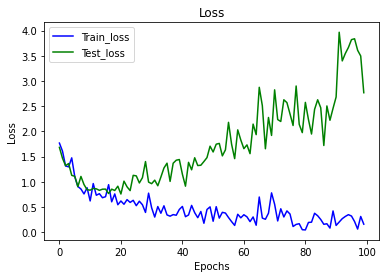

In [7]:
# visualization
(train_loss, train_acc, test_loss, test_acc) = result
plt.plot(range(config["epochs"]), train_loss, 'b-', label='Train_loss')
plt.plot(range(config["epochs"]), test_loss, 'g-', label='Test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


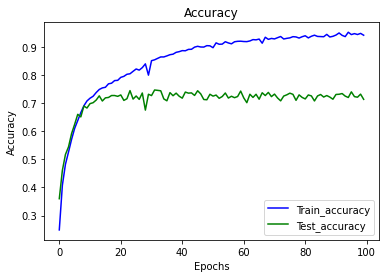

In [8]:
plt.plot(range(config["epochs"]), train_acc, 'b-', label='Train_accuracy')
plt.plot(range(config["epochs"]), test_acc, 'g-', label='Test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
print(max(test_acc).item())

0.7475000023841858
